# Ноутбук по проекту RDS-4 "Компьютер говорит "НЕТ" (Михеев Сергей)


# 1. Импорт библиотек
---

In [233]:
import numpy as np 
import pandas as pd 
from pandas import Series

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'


import warnings
warnings.filterwarnings("ignore")

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


In [234]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

# 2. Создание функций пользователя и их описание


Для удобства используются следующие функции:

* ***my_describe*** - отображает описательные статистики;
* ***show_heatmap*** - отображает связь между признаками на тепловой карте;
* ***show_plot_boxplot*** - строит гистограмму по столбцу и boxplot, показывает на нем среднее;
* ***all_metrics*** - выводит в виде датафрейма значения основных метрик классификации;
* ***show_roc_curve*** - отображает ROC-кривую;
* ***show_confusion_matrix*** - отображает confusion-матрицу;

In [235]:
def my_describe(df):
    """Отображение описательных статистик датафрейма в удобной форме"""
    temp = {}
    temp['Имя признака'] = list(df.columns)
    temp['Тип'] = df.dtypes
    temp['Всего значений'] = df.describe(include='all').loc['count']
    temp['Число пропусков'] = df.isnull().sum().values 
    temp['Кол-во уникальных'] = df.nunique().values
    temp['Минимум'] = df.describe(include='all').loc['min']
    temp['Максимум'] = df.describe(include='all').loc['max']
    temp['Среднее'] = df.describe(include='all').loc['mean']
    temp['Медиана'] = df.describe(include='all').loc['50%']
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T)
    return

In [236]:
def show_plot_boxplot(df, col_name, bins=10):
    """Построение гистограммы по столбцу и boxplot-а"""
    color_text = plt.get_cmap('PuBu')(0.95)
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (10, 5)
    _, axes = plt.subplots(2, 1)
    axes[0].hist(df, bins=bins)
    axes[0].set_title("Гистограмма и boxplot для признака '"+col_name+"'", color = color_text, fontsize=14)
    axes[1].boxplot(df, vert=False, showmeans = True)
    axes[1].set_title('')
    return

In [237]:
def all_metrics(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['P'] = [P,'Дефолт']
    dict_metric['N'] = [N,'БЕЗ дефолта']
    dict_metric['TP'] = [TP,'Истинно дефолтные']
    dict_metric['TN'] = [TN,'Истинно НЕ дефолтные']
    dict_metric['FP'] = [FP,'Ложно дефолтные']
    dict_metric['FN'] = [FN,'Ложно НЕ дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Точность = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Полнота = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df) 

In [238]:
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [239]:
def show_confusion_matrix(y_true, y_pred):
    """Функция отображает confusion-матрицу"""
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Дефолтный', 'НЕ дефолтный']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Реальные значения', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [240]:
def print_discharge(data, num_cols):
    """Функция отображает количество выбросов для заданных полей из датафрейма"""
    for column in num_cols:
        col = data.loc[:, column]
        median = col.median()
        IQR = col.quantile(0.75) - col.quantile(0.25)
        perc25 = col.quantile(0.25)
        perc75 = col.quantile(0.75)
        lower_limit = perc25 - 1.5*IQR
        upper_limit = perc75 + 1.5*IQR
        data2 = data[(data[column]>lower_limit)&(data[column]<upper_limit)]
        print(f'Признак -{column} , количество выбросов {len(data) - len(data2)}')
    return

In [241]:
def del_discharge(data, num_cols):
    """Функция удаляет выбросы из датафрейма"""
    data1= data.copy()
    for column in num_cols:
        col = data.loc[:, column]
        IQR = col.quantile(0.75) - col.quantile(0.25)
        perc25 = col.quantile(0.25)
        perc75 = col.quantile(0.75)
        lower_limit = perc25 - 1.5*IQR
        upper_limit = perc75 + 1.5*IQR
        data = data[(data[column]>lower_limit)&(data[column]<upper_limit)]
#         print(f'Признак -{column} Удалено -{len(data)-len(data1)} выбросов')
    return data

In [242]:
def plot_confusion_matrix(y_true, y_pred, d_my_font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP','FP'],['FN','TN']]
    
    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   

    plt.style.use('seaborn-paper')
    cmap=plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           
           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color = color_text)
    ax.set_xticklabels(classes, fontsize=12, color = 'black')
    ax.set_yticklabels(classes, fontsize=12, color = 'black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j]+'\n'+format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def confusion_matrix_f(d_name_columns, d_y, d_y_pred, d_my_font_scale, normalize=False):
    """Функция отображает матрицу ошибок"""
    class_names  = np.array(d_name_columns, dtype = 'U10')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(d_y, d_y_pred, d_my_font_scale, classes=class_names,
                        title='Матрица ошибок без нормализации')

    # Plot normalized confusion matrix
    if normalize:
        plot_confusion_matrix(d_y, d_y_pred, d_my_font_scale, classes=class_names, normalize=True,
                        title='Нормализованная матрица ошибок')

    plt.show()
    return

In [243]:
def PR_curve_with_area(d_y_true, d_y_pred_prob, d_my_font_scale):
    

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(d_y_true, d_y_pred_prob, pos_label=1)
    prc_auc_score_f = auc(recall, precision)
    plt.plot(precision, recall, lw=3, label='площадь под PR кривой = %0.3f)' % prc_auc_score_f)
    
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Точность \n Precision = TP/(TP+FP)')
    plt.ylabel('Полнота \n Recall = TP/P')
    plt.title('Precision-Recall кривая')
    plt.legend(loc="upper right")
    plt.show()
    return

# 3. Загрузка данных
---

> $train$ - данные для обучения модели; $test$ - данные для тестирования модели

Имеется информация из анкетных данных заемщиков и факт наличия дефолта. Описание полей:
* *client_id* - идентификатор клиента
* *education* - уровень образования
* *sex* - пол заемщика
* *age* - возраст заемщика
* *car* - флаг наличия автомобиля
* *car_type* - флаг автомобиля иномарки
* *decline_app_cnt* - количество отказанных прошлых заявок
* *good_work* - флаг наличия “хорошей” работы
* *bki_request_cnt* - количество запросов в БКИ
* *home_address* - категоризатор домашнего адреса
* *work_address* - категоризатор рабочего адреса
* *income* - доход заемщика
* *foreign_passport* - наличие загранпаспорта
* *sna* - связь заемщика с клиентами банка
* *first_time* - давность наличия информации о заемщике
* *score_bki* - скоринговый балл по данным из БКИ
* *region_rating* - рейтинг региона
* *app_date* - дата подачи заявки
* *default* - флаг дефолта по кредиту

In [244]:
# train = pd.read_csv('data/train.csv')#'/kaggle/input/sf-dst-scoring/train.csv'
# test = pd.read_csv('data/test.csv')
train = pd.read_csv(PATH_to_file+'train.csv')
test = pd.read_csv(PATH_to_file+'test.csv')

In [245]:
print(f'Размерность тренировочного датасета: {train.shape[0]} записей и {train.shape[1]} признаков.')
print(f'Размерность тестового датасета: {test.shape[0]} записей и {test.shape[1]} признаков.')

Размерность тренировочного датасета: 73799 записей и 19 признаков.
Размерность тестового датасета: 36349 записей и 18 признаков.


In [246]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем


# 4. Предварительный анализ данных
---

In [247]:
# Смотрим описательные характеристики тренировочного датасета
my_describe(df[df['Train']==1])

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,client_id,int64,73799,0,73799,1,110147,55138,55274
1,app_date,object,73799,0,120,NaN,NaN,NaN,NaN
2,education,object,73492,307,5,NaN,NaN,NaN,NaN
3,sex,object,73799,0,2,NaN,NaN,NaN,NaN
4,age,int64,73799,0,52,21,72,39.2806,37
5,car,object,73799,0,2,NaN,NaN,NaN,NaN
6,car_type,object,73799,0,2,NaN,NaN,NaN,NaN
7,decline_app_cnt,int64,73799,0,21,0,33,0.275749,0
8,good_work,int64,73799,0,2,0,1,0.164894,0
9,score_bki,float64,73799,0,69096,-3.62459,0.199773,-1.90472,-1.92082


In [248]:
# Смотрим описательные характеристики тестового датасета
my_describe(df[df['Train']==0])

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,client_id,int64,36349,0,36349,4,110148,54945.6,54657
1,app_date,object,36349,0,120,NaN,NaN,NaN,NaN
2,education,object,36178,171,5,NaN,NaN,NaN,NaN
3,sex,object,36349,0,2,NaN,NaN,NaN,NaN
4,age,int64,36349,0,51,21,71,39.186,37
5,car,object,36349,0,2,NaN,NaN,NaN,NaN
6,car_type,object,36349,0,2,NaN,NaN,NaN,NaN
7,decline_app_cnt,int64,36349,0,19,0,30,0.26804,0
8,good_work,int64,36349,0,2,0,1,0.166772,0
9,score_bki,float64,36349,0,34287,-3.5742,0.18882,-1.90415,-1.92082


In [249]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0


In [250]:
# Сохраним ID клиентов из тестового набора для последующего формирования Submission
id_test = df[df['Train']==0].client_id

**Резюме**: в тренировочном наборе 73799 записей о кредитной истории, в тестовой - 36349. Всего 19 переменных (18 признаков + целевая):
- *client_id* -идентификатор клиента, не нужная переменная;
- *app_date* - временная переменная;
- *sex*, *car*, *car_type*, *good_work*, *foreign_passport* - бинарные переменные;
- *education*, *region_rating*, *home_address*, *work_address*, *sna*, *first_time* - категориальные переменные;
- *age*, *decline_app_cnt*, *score_bki*, *bki_request_cnt*, *income* - числовые переменные;
- *default* - целевая переменная, индикатор дефолта.

Всего пропусков: 307+171 (307 - в наборе train, 171 - в наборе test), все пропуски в переменной ***education***. Столбец ***client_id*** содержит числовой признак клиента, который не несет полезной для модели информации. В бинарном признаке ***default*** - целевая переменная, индикатор дефолта по кредиту (0 - не обнаружен, 1 - дефлот обнаружен).

# 5. Feature Engineering
___
## 5.1. Обработка пропусков

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима **предварительная очистка данных**.

Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

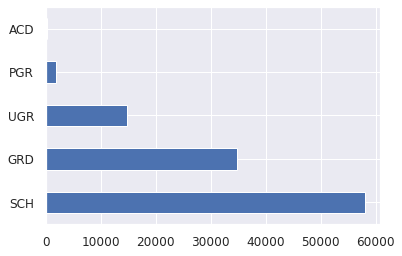

In [251]:
df['education'].value_counts().plot.barh()

In [252]:
# заполним пропуски в education самым популярным значением (по наборам train, test)
fill_value = df['education'].value_counts().index[0]
df['education'].fillna(fill_value, inplace=True)


In [253]:
# Проверим успешность заполнения пропусков для тренировочного набора
print('Всего пропусков на наборе train:', df[df['Train']==1].isna().sum().sum())
# Проверим успешность заполнения пропусков для тестового набора
print('Всего пропусков на наборе test:', df[df['Train']==0].isna().sum().sum())

Всего пропусков на наборе train: 0
Всего пропусков на наборе test: 36349


В наборе test остались пропуски в целевой переменной "default"

In [254]:
df['age']

0         62
1         59
2         25
3         53
4         48
          ..
110143    37
110144    64
110145    31
110146    27
110147    38
Name: age, Length: 110148, dtype: int64

## 5.2. Анализ переменных

In [255]:
# Создадим списки переменных (client_id не включаем в списки)
# временная переменная
time_cols = ['app_date']

# бинарные переменные (default - целевой признак, не включаем в список)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные 
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

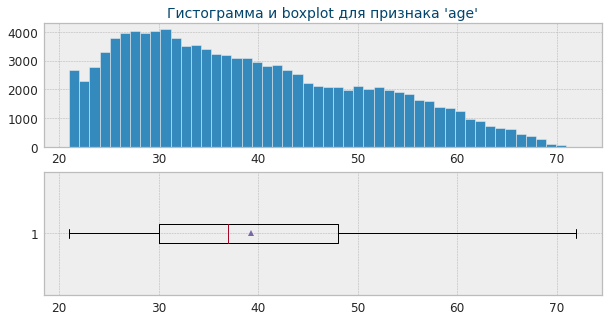

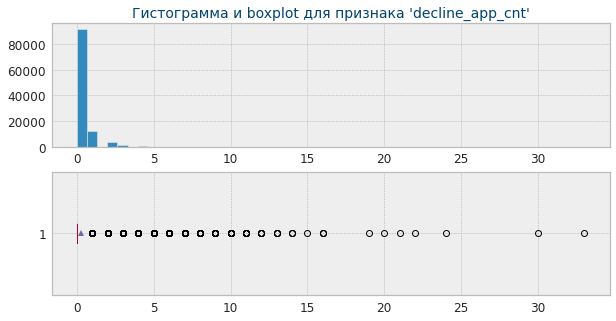

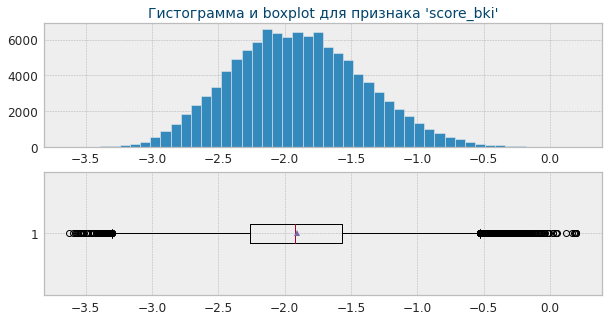

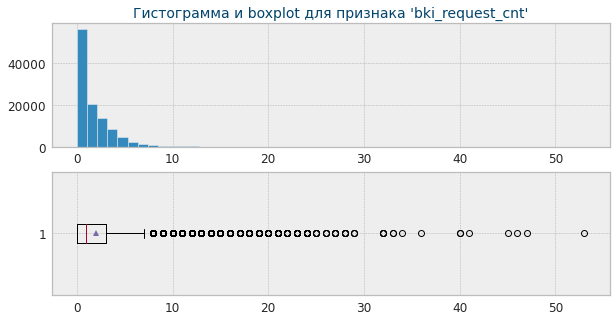

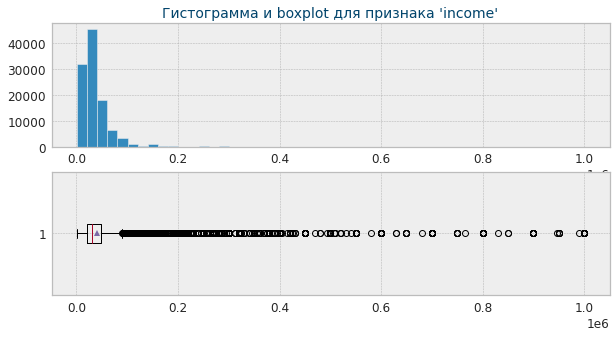

In [256]:
# Посмотрим на распределение и boxplot’ы для численных переменных.
for col in num_cols:
    show_plot_boxplot(df[col], col, bins=50)

## 5.3. Преобразование временной переменной

Проанализируем значения в столбце ***app_date*** - дата подачи заявки

In [257]:
df['app_date'].sample(5), test.app_date.sample(5)

(88111    27FEB2014
 89273    04APR2014
 57640    28JAN2014
 32646    17APR2014
 62743    09FEB2014
 Name: app_date, dtype: object,
 8633     28MAR2014
 819      29JAN2014
 13878    28APR2014
 10011    04MAR2014
 5900     19FEB2014
 Name: app_date, dtype: object)

In [258]:
# Преобразуем признак app_date в нужный формат
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
df.app_date.sample(5)

51606    2014-04-10
102278   2014-01-17
61623    2014-01-17
101838   2014-03-30
67115    2014-04-07
Name: app_date, dtype: datetime64[ns]

In [259]:
# Определим дату самой ранней заявки в датасетах
data_start = df.app_date.min()
data_start

Timestamp('2014-01-01 00:00:00')

Дата подачи самой первой заявки - 01 января 2014г.

Создадим новый столбец **delta_days**, в котором будет записана разница между датой, указанной в столбце **app_date** и датой подачи первой заявки (01.01.2014). Включим этот столбец в состав числовых.

In [260]:
df['delta_days'] = (df.app_date - data_start).dt.days.astype('int')
num_cols.append('delta_days')

Не числовой столбец **app_date** удалим из обоих наборов (учебного и тестового) 

In [261]:
df.drop(['app_date'], axis=1, inplace=True)


## 5.4. Создание новых признаков

In [262]:
# Созданим новые числовые признаки:
df['bki_request_cnt^1/2'] = df['bki_request_cnt']**(1/2)
df['log_bki'] = np.log(df['bki_request_cnt']+1)
df['income^1/2'] = df['income']**(1/2)
df['log_income'] = np.log(df['income']+1)
df['log_decline_app_cnt'] = np.log(df['decline_app_cnt']+1)
df['decline_app_cnt^1/2'] = df['decline_app_cnt']**(1/2)
df['log_age'] = np.log(df['age']+1)
df['delta_days^2'] = df['delta_days']**2
df['log_delta_days'] = np.log(df['delta_days']+1)
df['score_bki^2'] = df['score_bki']
# Внесем новые признаки в список
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'log_age', 
            'log_decline_app_cnt', 'decline_app_cnt^1/2', 'log_bki', 'bki_request_cnt^1/2',
           'log_income', 'income^1/2', 'log_delta_days', 'delta_days^2', 'score_bki', 'score_bki^2']


## 5.5 Оценка корреляций

Оценим корреляцию Пирсона для непрерывных переменных. Помним, что сильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

Text(0.5, 1.0, 'Матрица корреляции между числовыми переменными')

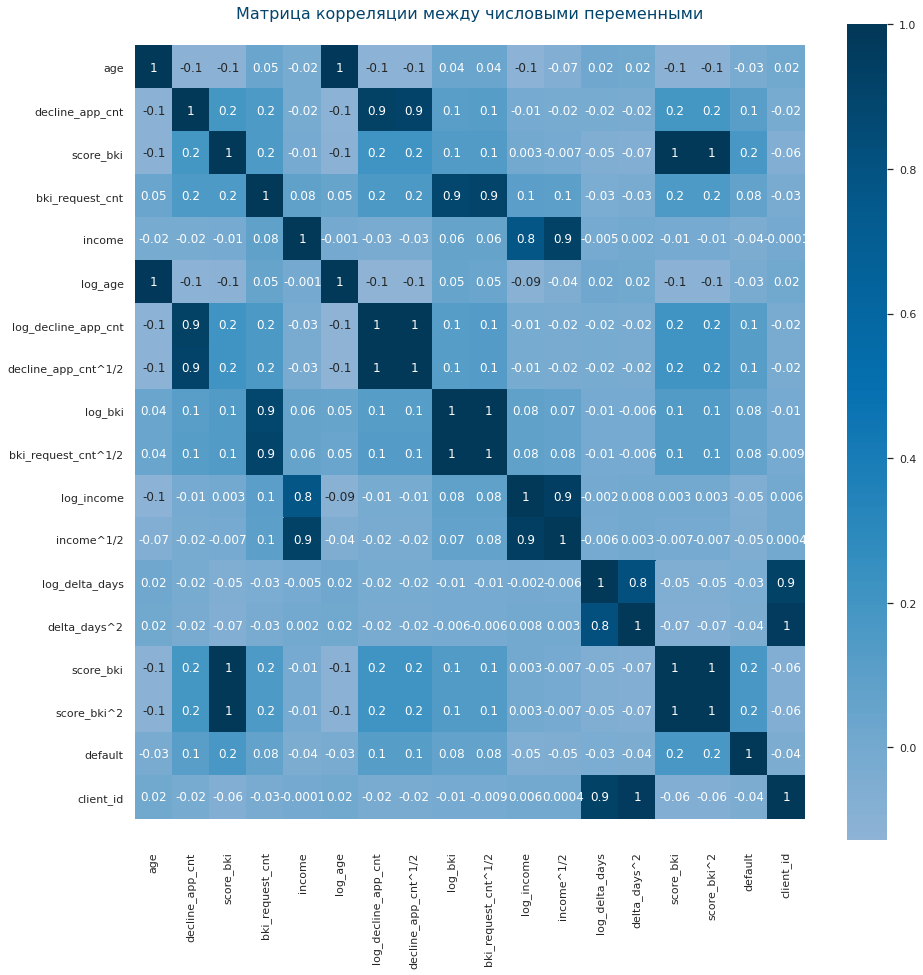

In [263]:
corr_list = num_cols+['default']+['client_id']
plt.style.use('seaborn-paper')
fig, ax = plt.subplots(figsize=(15, 15))
color_text = plt.get_cmap('PuBu')(0.95)
sns.set(font_scale=1, style='whitegrid')
plt.subplot(111)
h = sns.heatmap(df[df['Train']==1][corr_list].corr(), annot = True, cmap= "PuBu", center= 0, fmt='.1g')
b, t = plt.ylim()
plt.ylim(b+0.5, t-0.5)
h.set_title('Матрица корреляции между числовыми переменными',  fontsize=16, color = color_text)

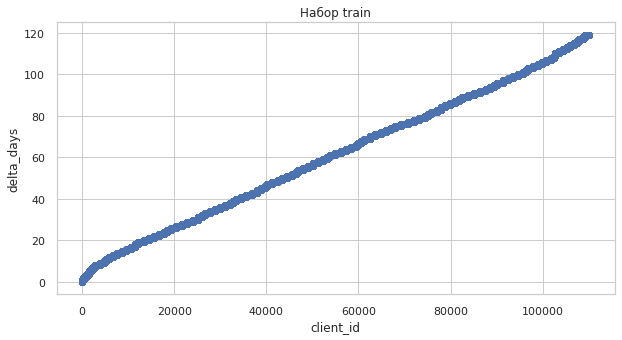

In [264]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.scatter(x=df['client_id'], y=df['delta_days'], marker='o')
axes.set_xlabel('client_id')
axes.set_ylabel('delta_days')
axes.set_title('Набор train')
plt.show();

По графику можно сделать вывод, что в банке нумерация клиентов велась в зависимости от дня обращения.
Эти признаки будут сильно скоррелированными.

Видно, что скоррелированными являются признаки **client_id** и **delta_deys**. Удалим **client_id** и избавимся от мультиколлинеарности. В рестовом наборе **client_id** оставим, чтобы потом записать результаты по **client_id**.


In [265]:
train.drop(['client_id'], axis=1, inplace=True)

Есть сильно скоррелированные признаки:

-  **age, log_age**
-  **decline_app_cnt, log_decline_app_cnt, decline_app_cnt^1/2**
-  **bki_request_cnt, log_bki, bki_request_cnt^1/2**
-  **income, log_income, income^1/2**
-  **delta_deys, 'log_delta_deys', 'delta_deys^2'**

Это те признаки, которые мы добавили преобразуя числовые признаки различными способами. Для принятия решения об удалении тех или иных признаков нам требуется оценить значимость признаков для модели. Это выполним чуть ниже
 

Построим **boxplot**’ы для численных переменных для сравнения дефолтных и недефолтных заемщиков.

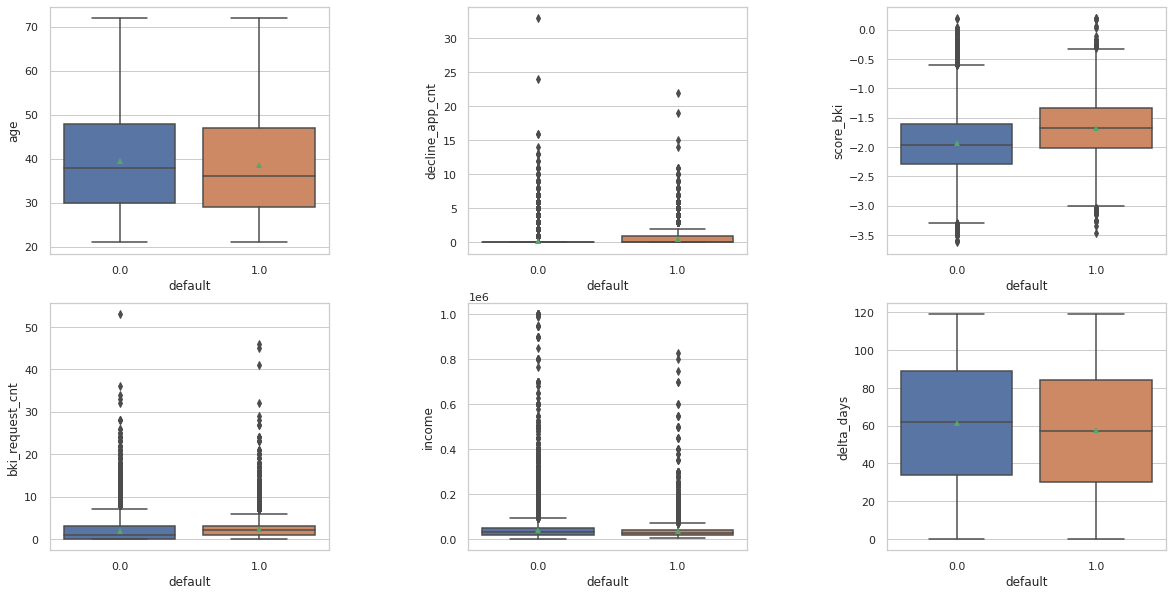

In [266]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'delta_days']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=df, orient = 'v', ax=axes[i], showfliers=True,  showmeans = True)

***Выводы (анализ boxplot-ов) для числовых переменных***:
* **age**: дефолтные клиенты в среднем младше
* **decline_app_cnt**: дефолтные клиенты в среднем имеют большее количество отмененных заявок
* **score_bki**: дефолтные клиенты в среднем имеют больший скоринговый балл по данным из БКИ
* **bki_request_cnt**: дефолтные клиенты в среднем имеют больше запросов в БКИ
* **income**: дефолтные клиенты в среднем имеют более низкий доход
* **delta_deys**: дефолтные клиенты в среднем обращались ранее

### Значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA))

Для оценки значимости числовых переменных будем использовать функцию **f_classif** из библиотеки **sklearn**.

В качестве меры значимости мы будем использовать значение  ***f*** -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

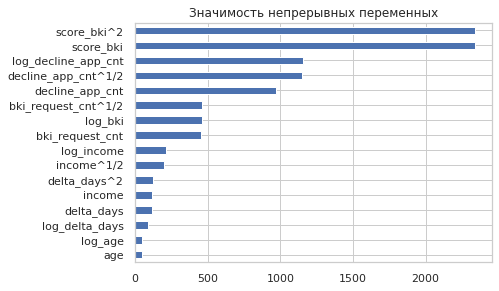

In [267]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'score_bki^2', 'bki_request_cnt', 'income', 'log_age', 
            'log_decline_app_cnt', 'decline_app_cnt^1/2', 'log_bki', 'bki_request_cnt^1/2',
           'log_income', 'income^1/2', 'log_delta_days', 'delta_days^2', 'delta_days']
imp_num = Series(f_classif(df[df['Train']==1][num_cols], df[df['Train']==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных')

Исходя из важности переменных и сорреляции между собой в дальнейшем используем следующие признаки:
- **score_bki^2** (оценка плательщика БКИ в квадрате) - самый значимый показатель по ANOVA f-test;
- **log_decline_app_cnt** (логарифм от кол-ва отказанных заявок);
- **bki_request_cnt^1/2'** (квадратный корень из количества запросов в БКИ); 
- **log_income** (логарифм от дохода заемщика);
- **delta_days^2** (количество дней от  первой заявки возведенное в квадрат);
- **log_age** (логарифм от возраста).

In [268]:
num_cols = ['score_bki^2', 'log_decline_app_cnt', 'bki_request_cnt^1/2', 'log_income', 'delta_days^2', 'log_age']


## 5.6. Преобразование бинарных переменных¶

Убедимся в том, что в бинарных переменных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport') записано всего два значения

In [269]:
print('Анализ бинарных признаков датасета')
for col in bin_cols:
    print(f'Уникальные записи в столбце {col}:')
    print(df[col].value_counts())

Анализ бинарных признаков датасета
Уникальные записи в столбце sex:
F    61836
M    48312
Name: sex, dtype: int64
Уникальные записи в столбце car:
N    74290
Y    35858
Name: car, dtype: int64
Уникальные записи в столбце car_type:
N    89140
Y    21008
Name: car_type, dtype: int64
Уникальные записи в столбце good_work:
0    91917
1    18231
Name: good_work, dtype: int64
Уникальные записи в столбце foreign_passport:
N    93721
Y    16427
Name: foreign_passport, dtype: int64


Преобразуем бинарные переменные при помощи класса **LabelEncoder**. Исходя из описания, наши признаки строго бинарные (принимают только два значения) и сюрпризов (новых неизвестных значений) быть не должно.

In [270]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    
# Убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,bki_request_cnt^1/2,log_bki,income^1/2,log_income,log_decline_app_cnt,decline_app_cnt^1/2,log_age,delta_days^2,log_delta_days,score_bki^2
0,25905,SCH,1,62,1,1,0,0,-2.008753,1,...,1.000000,0.693147,134.164079,9.798183,0.000000,0.000000,4.143135,961,3.465736,-2.008753
1,63161,SCH,0,59,0,0,0,0,-1.532276,3,...,1.732051,1.386294,137.840488,9.852247,0.000000,0.000000,4.094345,4900,4.262680,-1.532276
2,25887,SCH,1,25,1,0,2,0,-1.408142,1,...,1.000000,0.693147,173.205081,10.308986,1.098612,1.414214,3.258097,961,3.465736,-1.408142
3,16222,SCH,0,53,0,0,0,0,-2.057471,2,...,1.414214,1.098612,100.000000,9.210440,0.000000,0.000000,3.988984,484,3.135494,-2.057471
4,101655,GRD,1,48,0,0,0,1,-1.244723,1,...,1.000000,0.693147,173.205081,10.308986,0.000000,0.000000,3.891820,11449,4.682131,-1.244723


### 5.7. Преобразование категориальных переменных

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа...

Для оценки значимости категориальных и бинарных переменных будем использовать функцию *mutual_info_classif* из библиотеки *sklearn*.
*mutual_info_classif* сначала требует, чтобы категориальные значения были сопоставлены с целочисленными значениями, и нам в этом помешает *education* столбец. Преобразем этот признак в численный формат, а затем определим важность признаков.

In [271]:
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])


### Значимость категориальных  и бинарных переменных признаков

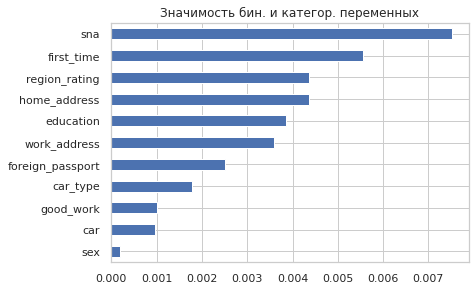

In [272]:
# Определим важность признаков
imp_cat = Series(mutual_info_classif(df[df['Train']==1][bin_cols + cat_cols], df[df['Train']==1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных')

Визуализация важности признаков показывает, что самым значимым из категориальных и бинарных является признак *sna*, а наименее важным по мнению *mutual_info_classif* является признак *sex*.

## 5.8. Определение дисбаланса классов
Посмотрим, каких клиентов у банка больше: дефолтных или добросовестных

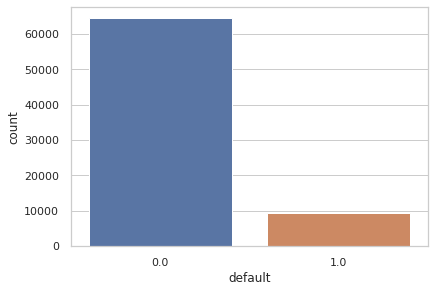

In [273]:
sns.countplot(df['default']);

Видно что классы не сбалансированы, определим соотношение классов:

In [274]:
df['default'].value_counts(normalize=True)


0.0    0.873006
1.0    0.126994
Name: default, dtype: float64

Доля дефолтных клиентов- **0.127**, не дефолтных - **0.873**

In [275]:
# Посмотрим на данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   client_id            110148 non-null  int64  
 1   education            110148 non-null  int64  
 2   sex                  110148 non-null  int64  
 3   age                  110148 non-null  int64  
 4   car                  110148 non-null  int64  
 5   car_type             110148 non-null  int64  
 6   decline_app_cnt      110148 non-null  int64  
 7   good_work            110148 non-null  int64  
 8   score_bki            110148 non-null  float64
 9   bki_request_cnt      110148 non-null  int64  
 10  region_rating        110148 non-null  int64  
 11  home_address         110148 non-null  int64  
 12  work_address         110148 non-null  int64  
 13  income               110148 non-null  int64  
 14  sna                  110148 non-null  int64  
 15  first_time       

# 6. Подготовка данных к машинному обучению

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

## 6.1.  One Hot Encoding 


In [276]:
# Реализуем метод  One Hot Encoding 
X_cat = OneHotEncoder(sparse = False).fit_transform(df[df['Train']==1][cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(df[df['Train']==0][cat_cols].values)

## 6.2.  Стандартизация (StandardScaler)
Стандартизацию проводим отдельно для трейна и теста

In [277]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[df['Train']==1][num_cols].values)
X_num_test = StandardScaler().fit_transform(df[df['Train']==0][num_cols].values)

# Объединяем
X = np.hstack([X_num, df[df['Train']==1][bin_cols].values, X_cat])
Test = np.hstack([X_num_test, df[df['Train']==0][bin_cols].values, X_cat_test])
y = df[df['Train']==1]['default'].values

In [278]:
# Проверяем размеры наборов train и test
train.shape, test.shape, X.shape, Test.shape

((73799, 19), (36349, 19), (73799, 37), (36349, 37))

# 7. Построение модели

## 7.1. Первая модель

,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,41.000000,Истинно дефолтные
TN,12868.000000,Истинно НЕ дефолтные
FP,65.000000,Ложно дефолтные
FN,1786.000000,Ложно НЕ дефолтные
Accuracy,0.874593,Accuracy=(TP+TN)/(P+N)
Precision,0.386792,Точность = TP/(TP+FP)
Recall,0.022441,Полнота = TP/P
F1-score,0.042421,Среднее гармоническое Precision и Recall


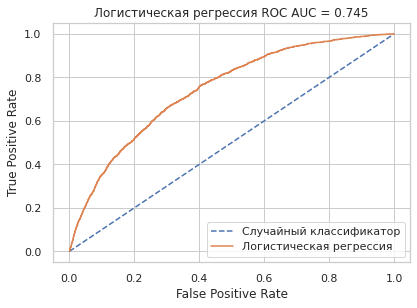

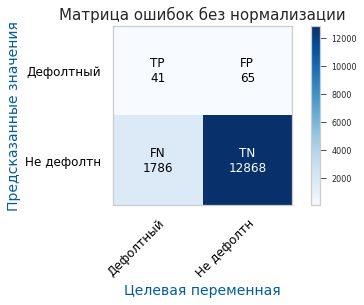

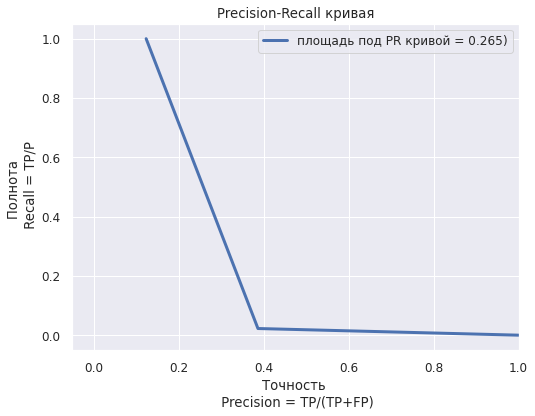

In [279]:
# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_1 = LogisticRegression(random_state=RANDOM_SEED)

model_1.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_1.predict_proba(X_test)[:,1]
y_pred = model_1.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2)
PR_curve_with_area(y_test, y_pred, 1.1)

**ВЫВОДЫ**: Модель неадекватно определяет дефолтных клиентов. Слишком большая ошибка второго рода. На основе этой модели банк будет выдавать кредиты заемщикам, которые не смогут их вернуть. Есть риск потерять все деньги. При этом видно что такой показатель, как ROC_AUC достаточно большой - 0.7449. Он плохо оценивает эффективность алгоритма на несбалансированных данных). Значение точности, полноты и f1 сигнализирует о том что что-то не в порядке. Построенная модель очень плохая: из матрицы ошибок видно, что мы почти не угадываем дефолтных клиентов (42 из 1827). Это показывает и метрика recall = 0.02299.


## 7.2. Вторая модель
Попробуем выполнить нормировку с помощью RobastScaler, которая при нормализации использует  медианы, квантили, и поэтому не чувствительна с выбросам и может приводить к лучшим результатам.

,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,41.000000,Истинно дефолтные
TN,12868.000000,Истинно НЕ дефолтные
FP,65.000000,Ложно дефолтные
FN,1786.000000,Ложно НЕ дефолтные
Accuracy,0.874593,Accuracy=(TP+TN)/(P+N)
Precision,0.386792,Точность = TP/(TP+FP)
Recall,0.022441,Полнота = TP/P
F1-score,0.042421,Среднее гармоническое Precision и Recall


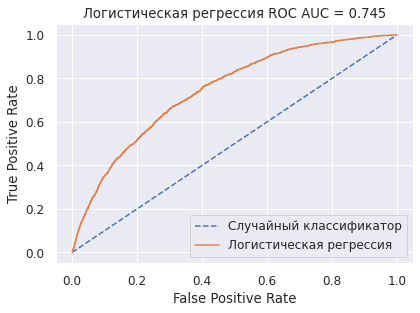

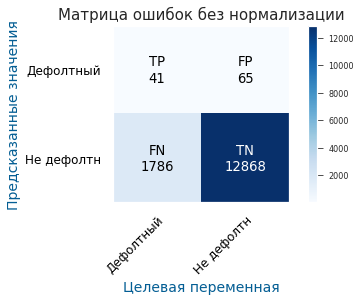

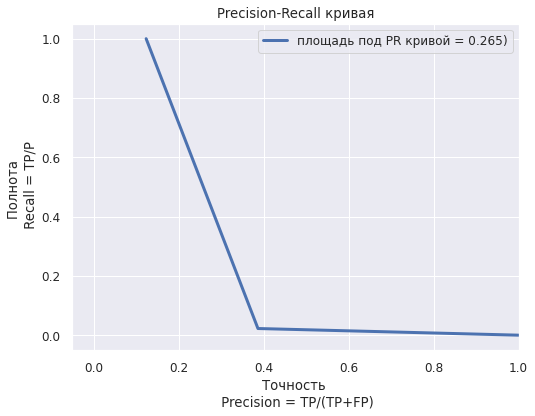

In [280]:
# RobastScaler
X_num = RobustScaler().fit_transform(df[df['Train']==1][num_cols].values)
X_num_test = RobustScaler().fit_transform(df[df['Train']==0][num_cols].values)

# Объединяем
X = np.hstack([X_num, df[df['Train']==1][bin_cols].values, X_cat])
Test = np.hstack([X_num_test, df[df['Train']==0][bin_cols].values, X_cat_test])
y = df[df['Train']==1]['default'].values

# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_2 = LogisticRegression(random_state=RANDOM_SEED)

model_2.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_2.predict_proba(X_test)[:,1]
y_pred = model_2.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2)
PR_curve_with_area(y_test, y_pred, 1.1)

**ВЫВОДЫ**: RobustScaler не улучшил качество модели.

## 7.3. Третья модель. Веса классов.

В двух моделях мы получили результаты низкого качества в связи с несбалансированностью классов. Во входных данных к модели доля дефолтных клиентов- **0.127**, не дефолтных - **0.873**. Модели не знали о том, что классы не сбалансированы и принимали решение на основании наибольшего количества случаев. Зададим веса классов таким образом, чтобы они были обратно пропорциональны доли встречающихся случаев, мы увеличим вес ошибки редко встречающегося класса. Для таких целей в модели имеется параметр class_weight={0:0.123, 1:0.827}

,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,1247.000000,Истинно дефолтные
TN,8728.000000,Истинно НЕ дефолтные
FP,4205.000000,Ложно дефолтные
FN,580.000000,Ложно НЕ дефолтные
Accuracy,0.675813,Accuracy=(TP+TN)/(P+N)
Precision,0.228723,Точность = TP/(TP+FP)
Recall,0.682540,Полнота = TP/P
F1-score,0.342629,Среднее гармоническое Precision и Recall


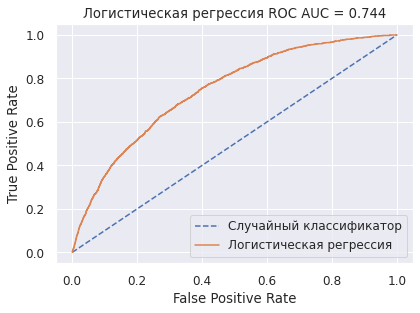

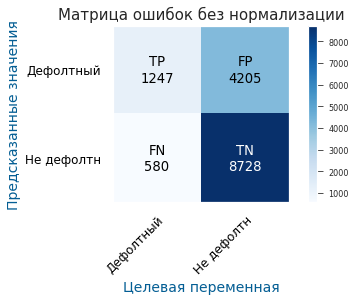

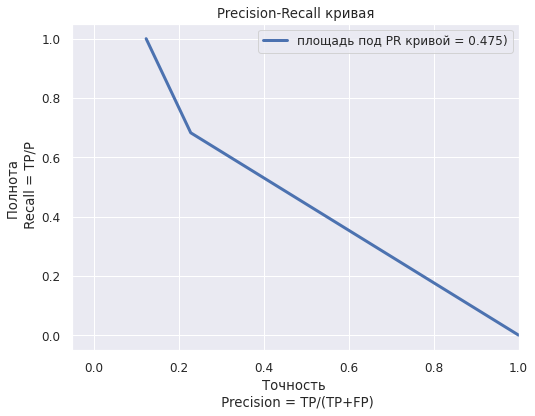

In [281]:
# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_3 = LogisticRegression(class_weight={0:0.123, 1:0.827})

model_3.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_3.predict_proba(X_test)[:,1]
y_pred = model_3.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2)
PR_curve_with_area(y_test, y_pred, 1.1)

**ВЫВОДЫ**: Качество модели определяемое по матрице ошибок резко выросло: из 1827 дефолтных клиентов угадали 1247. Но возросло количество недефолтных клиентов, которых мы определили как дефолтные (ошибка 1 рода). Это значит что банк может недополучить прибыль не выдавая кредит тем, кто может его вернуть. Таких клиентов 4205 из 12933. При этом видно что такой показатель, как ROC_AUC достаточно большой - 0.7445. Значение f1=0.3426.  Метрика Precision снизилась до 0.2287. Задание веса классов позволило повысить качество модели.


## 7.4. Четвертая модель. Автоматическое определение веса классов.

В предыдущей модели мы задали веса классов вручную, но такой метод может привести к снижению качества при другой выборке, когда веса классов изменятся. Для этого в модели можно задать параметр автоматического определения веса классов. class_weight='balanced'

,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,1247.000000,Истинно дефолтные
TN,8728.000000,Истинно НЕ дефолтные
FP,4205.000000,Ложно дефолтные
FN,580.000000,Ложно НЕ дефолтные
Accuracy,0.675813,Accuracy=(TP+TN)/(P+N)
Precision,0.228723,Точность = TP/(TP+FP)
Recall,0.682540,Полнота = TP/P
F1-score,0.342629,Среднее гармоническое Precision и Recall


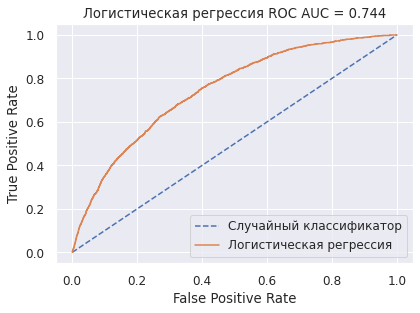

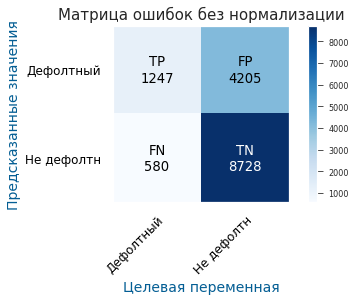

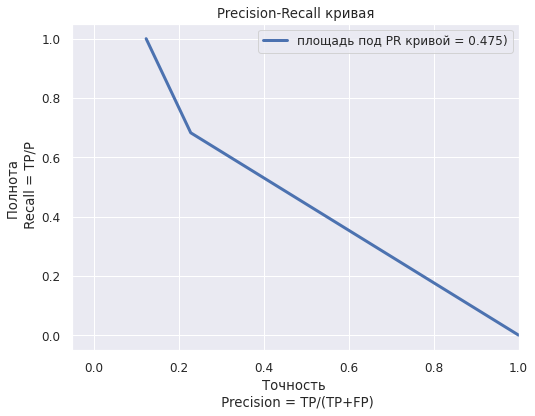

In [282]:
# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_4 = LogisticRegression(class_weight='balanced')

model_4.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_3.predict_proba(X_test)[:,1]
y_pred = model_3.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2)
PR_curve_with_area(y_test, y_pred, 1.1)

**ВЫВОДЫ**: Из 1827 дефолтных клиентов угадали 1249. Немного выросла ошибка 1 рода. Количество недефолтных клиентов, которых мы определили как дефолтные. Таких клиентов 4296 из 12933. При этом видно что такой показатель, как ROC_AUC почти не изменился - 0.7444. Значение f1=0.3388.  Метрика Precision = 0.2252. Задание веса классов позволило повысить качество модели. В целом можно сказать, что задание автоматического веса классов потенциально может дать более стабильный и качественный результат.

## 7.5. Пятая модель. Работа с выбросами.

Определим количество выбросов в числовых переменных:

In [283]:
num_cols = ['score_bki^2', 'log_decline_app_cnt', 'bki_request_cnt^1/2', 'log_income', 'delta_days^2', 'log_age']
print_discharge(df[df['Train']==1], num_cols)

Признак -score_bki^2 , количество выбросов 351
Признак -log_decline_app_cnt , количество выбросов 73799
Признак -bki_request_cnt^1/2 , количество выбросов 81
Признак -log_income , количество выбросов 1767
Признак -delta_days^2 , количество выбросов 0
Признак -log_age , количество выбросов 0


Удалим выбросы из признаков log_income, score_bki^2, bki_request_cnt^1/2:

In [284]:
discharge_cols = ['log_income', 'score_bki^2', 'bki_request_cnt^1/2']
df_without_discharge = del_discharge(df[df['Train']==1], discharge_cols)

,Значение,Описание метрики
P,1793.000000,Дефолт
N,12532.000000,БЕЗ дефолта
TP,1185.000000,Истинно дефолтные
TN,8361.000000,Истинно НЕ дефолтные
FP,4171.000000,Ложно дефолтные
FN,608.000000,Ложно НЕ дефолтные
Accuracy,0.666387,Accuracy=(TP+TN)/(P+N)
Precision,0.221247,Точность = TP/(TP+FP)
Recall,0.660904,Полнота = TP/P
F1-score,0.331515,Среднее гармоническое Precision и Recall


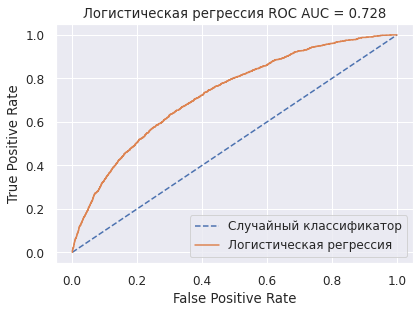

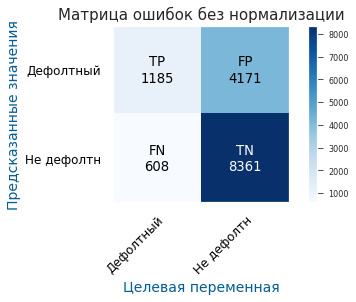

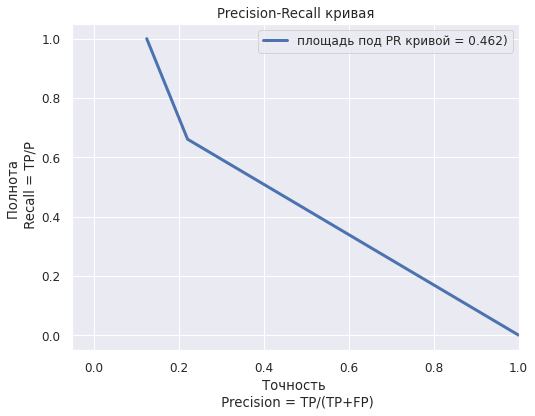

In [285]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df_without_discharge[cat_cols].values)

# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df_without_discharge[num_cols].values)
X_num_test = StandardScaler().fit_transform(df_without_discharge[num_cols].values)

# Объединяем
X = np.hstack([X_num, df_without_discharge[bin_cols].values, X_cat])
# Test = np.hstack([X_num_test, df_without_discharge[bin_cols].values, X_cat_test])
y = df_without_discharge['default'].values

# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_5 = LogisticRegression(class_weight='balanced')

model_5.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_5.predict_proba(X_test)[:,1]
y_pred = model_5.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2)
PR_curve_with_area(y_test, y_pred, 1.1)

**ВЫВОДЫ**: По сравнению с предыдущей моделью все показатели снизились: F1-score = 0.3315, ROC_AUC = 0.7283, Recall = 0.6609, Precision=0,2212. Видимо в процессе удаления выбросов мы удалии значимые для модели данные.

## 7.6. Шестая модель. Автоматический подбор гиперпараметров.



In [286]:
# Реализуем метод  One Hot Encoding 
X_cat = OneHotEncoder(sparse = False).fit_transform(df[df['Train']==1][cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(df[df['Train']==0][cat_cols].values)

# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[df['Train']==1][num_cols].values)
X_num_test = StandardScaler().fit_transform(df[df['Train']==0][num_cols].values)

# Объединяем
X = np.hstack([X_num, df[df['Train']==1][bin_cols].values, X_cat])
Test = np.hstack([X_num_test, df[df['Train']==0][bin_cols].values, X_cat_test])
y = df[df['Train']==1]['default'].values

# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

C = np.logspace(0, 4, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# указываем модель (в нашем случае лог регрессия), гиперпараметры
model = LogisticRegression(random_state=RANDOM_SEED)

# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                          'class_weight': ['none', 'balanced'],
                          'max_iter': [50], 'multi_class': ['auto', 'ovr'],
                          'penalty': ['l1'], 'so...
                          'tol': [0.001]},
                         {'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                          'class_weight': ['none', 'balanced'],
                          'max_iter': [50], 'multi_class': ['auto', 'ovr'],
                          'penalty': ['none'],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']

In [287]:
# Смотрим лучшие гиперпараметры
model_6 = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model_6.get_params()
print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print(f'  {param_name} => {best_parameters[param_name]}')

Лучшие значения параметров:
  C => 1.0
  class_weight => balanced
  dual => False
  fit_intercept => True
  intercept_scaling => 1
  l1_ratio => None
  max_iter => 50
  multi_class => auto
  n_jobs => None
  penalty => l2
  random_state => 42
  solver => saga
  tol => 0.001
  verbose => 0
  warm_start => False


,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,1249.000000,Истинно дефолтные
TN,8635.000000,Истинно НЕ дефолтные
FP,4298.000000,Ложно дефолтные
FN,578.000000,Ложно НЕ дефолтные
Accuracy,0.669648,Accuracy=(TP+TN)/(P+N)
Precision,0.225167,Точность = TP/(TP+FP)
Recall,0.683634,Полнота = TP/P
F1-score,0.338758,Среднее гармоническое Precision и Recall


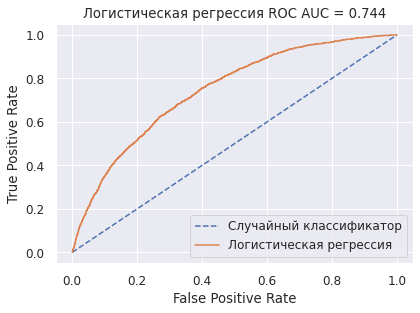

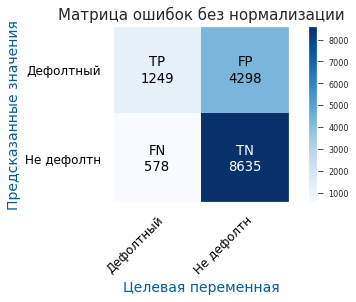

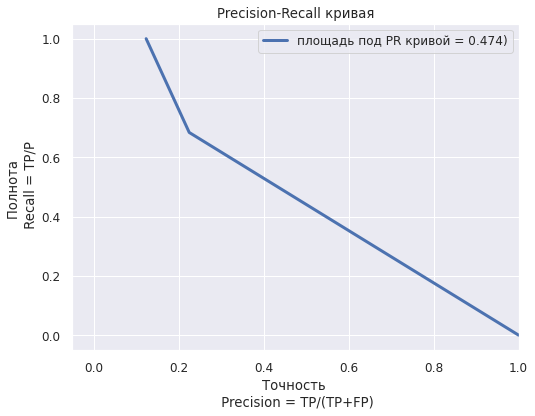

In [288]:
model_6 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l1', 
                           solver='liblinear', 
                           verbose=0, 
                           warm_start=False, max_iter=1000)

model_6.fit(X_train, y_train)

y_pred_prob = model_6.predict_proba(X_test)[:,1]
y_pred = model_6.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2)
PR_curve_with_area(y_test, y_pred, 1.1)

**ВЫВОДЫ**: У построенной модель по сравнению с моделью №4, стал немного хуже ROC_AUC = 0.74444, но для окончательного варианта выберем эту модель, поскольку она проверялась на большом количестве гиперпараметров и может лучше себя показать на итоговом Тесте 

# 8. Submission

В ходе анализа с данными проводилась следующая работа:
* заполнили пропуски в **test.education** самым популярным значением;
* преобразовали признак **app_date** (дата подачи заявки) в нужный формат;
* создали новый столбец **delta_deys**, в котором будет записана разница между датой, указанной в столбце **app_date** и датой подачи первой заявки (01.01.2014);
* создали новые признаки **score_bki^2**, **log_decline_app_cnt**, **bki_request_cnt^1/2**, **log_income**, **delta_days^2**, **log_age** и использовали их в модели
* удалили из тестового набора не числовой столбец **app_date**;
* преобразовали бинарные переменные при помощи класса LabelEncoder;
* преобразовали  признак **education** в численный формат;
* стандартизировали числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных

In [289]:
submission_pred_prob = model_6.predict_proba(Test)[:,1]
submission_predict = model_6.predict(Test)

submission = pd.DataFrame({'client_id': id_test, 
                            'default': submission_pred_prob})
submission.to_csv('submission.csv', index=False)

submission

,client_id,default
73799,74835,0.205222
73800,17527,0.789902
73801,75683,0.307733
73802,26883,0.419273
73803,28862,0.141854
...,...,...
110143,83775,0.765223
110144,106254,0.107858
110145,81852,0.783132
110146,1971,0.611057


В целом в проекте было протестировано 6 моделей. Нам удалось:
- сбалансировать классы вручную и автоматически;
- убрать выбросы;
- провести нормировку признаков различными способами;
- подобрать автоматические гиперпараметры.

Лучшие показатели получились у модели №4, но для итогового теста применили модель №6 с автоматическими гиперпараметрами, которая может лучше сработать на итоговом тесте. Для реального внедрения показатели не позволяют достаточно точно отличать дефолтного от недефолтного заемщика. В данных не хватает дополнительных признаков, которые помогут сделать более качественную оценку. Возможно стоит собрать и включить модель данные из соцсетей, которые позволят оценить психологический портрет заемщика.